# Detecting COVID-19 in X-ray Images - PyImage Search by Adrian Rosebrock

This tutorial from PyImage search focuses on detecting COVID-19 through the use of X-ray images. COVID-19 attacks the epithelial cells that line the respiratory tract, therefore X-rays can be used to examine the health of a patient's lungs. 


Source: https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

Disclaimer
This blog post on automatic COVID-19 detection is for educational purposes only. It is not meant to be a reliable, highly accurate COVID-19 diagnosis system, nor has it been professionally or academically vetted.

### Take-aways:
- Educational purposes :)
- Obtained ~90-92% accuracy solely on the X-ray images
- Obtained 100% sesitivity and 80% specificity. This implies that:
    - True Positives (those with COVID-19) are accurately identified 100% of the time.
    - True Negatives (those without COVID-19) are accurately identified 80% of the time.
- Despite having limited data, network did not overfit.
- Limitation: Amount of Data :(



In [1]:
pip install tensorflow

  Found existing installation: scipy 1.3.2
    Uninstalling scipy-1.3.2:
      Successfully uninstalled scipy-1.3.2
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import relevant libraries
# Tensorflow 2.0 and Keras for Deep learning
# Scikit-learn for Machinelearning processes
# Matplotlib for plotting
# OpenCV for loading and Preprocessing images

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
# Parse command line arguments and initialize hyperparameters

# parser = argparser.ArgumentParser()

# parser.add_argument("-d", "--dataset", required=True,
#                     help="Path to input dataset")
# parser.add_argument("-p", "--plot", type=str, default="plot.png",
#                     help="path to output loss/accuracy plot")
# parser.add_argument()
# parser.add_argument()

In [1]:
# Initialize initial Learning rate, number of Epochs to train for and batch size

INIT_LR = 1e-3
EPOCHS = 25
BS = 8

### Load Dataset and Preprocess Images

In [3]:
# Get Images from the dataset directory and initialize
# list of images and image classes
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("dataset"))
images = []
labels = []
#print(imagePaths)

# Loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the image, swap color channels, resize to 224x224
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # Update data and labels lists
    images.append(image)
    labels.append(label)
    

# Convert the data and labels to Numpy arrays while scaling pixel
# intensities to range [0, 1]
images = np.array(images) / 255.0
labels = np.array(labels)

[INFO] Loading images...


In [4]:
# Perform one-hot encoding on the labels
label_bin = LabelBinarizer()
labels = label_bin.fit_transform(labels)
labels = to_categorical(labels)

# Split dataset into training and testing
train_X, test_X, train_y, test_y = train_test_split(images, labels,
                                                   test_size=0.2, stratify=labels,
                                                   random_state=42)

# Initialize the training data augmentation object
train_aug = ImageDataGenerator(rotation_range=15, 
                               fill_mode="nearest")

Initialize VGGNet Model and set up for fine-tuning

In [5]:
# Load VGG16 network, ensuring the FC (Fully Connected) layer 
# sets are left off

base_model = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top 
# of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# Place the head FC model on top of the base model (this will
# become the actual model we will train)
model = Model(inputs=base_model.input, outputs=head_model)

# Loop over all layers in the base model and freeze them so they
# will not be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

Compile and train the COVID-19 Deep learning model

In [6]:
# Compile model
print("[INFO] compiling model...")
optimize = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimize,
             metrics=["accuracy"])

# Train the head of the network
print("[INFO] Training head...")
H = model.fit_generator(train_aug.flow(train_X, train_y, batch_size=BS),
                       steps_per_epoch=len(train_X) // BS,
                       validation_data=(test_X, test_y),
                       validation_steps=len(test_X) // BS,
                       epochs=EPOCHS)

[INFO] compiling model...
[INFO] Training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 87s 17s/step - loss: 0.7765 - accuracy: 0.5250 - val_loss: 0.5036 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 53s 11s/step - loss: 0.7927 - accuracy: 0.4750 - val_loss: 0.5544 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 58s 12s/step - loss: 0.6873 - accuracy: 0.5500 - val_loss: 0.5047 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 57s 11s/step - loss: 0.6832 - accuracy: 0.6000 - val_loss: 0.4702 - val_accuracy: 0.8750
Epoch 5/25
5/5 [==============================] - 54s 11s/step - loss: 0.5710 - accuracy: 0.7750 - val_loss: 0.4653 - val_accuracy: 0.8750
Epoch 6/25
5/5 [==============================] - 54s 11s/step - loss: 0.5241 - accuracy: 0.7500 - val_loss: 0.4

Then we evaluate the model

In [7]:
# Make predictions on the testing set
print("[INFO] Evaluating network...")
predIdxs = model.predict(test_X, batch_size=BS)

# For each image in the test set, we need to find the index
# of the label with corresponnding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs,
                           target_names=label_bin.classes_))

[INFO] Evaluating network...
              precision    recall  f1-score   support

       covid       0.83      1.00      0.91         5
      normal       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



Compute Confusion Matrix for statistica evaluation.

In [9]:
# Compute Confusion matrix and use it to derive the raw accuracy, 
# sensitivity and specificity
conf_matrix = confusion_matrix(test_y.argmax(axis=1), predIdxs)
total = sum(sum(conf_matrix))
acc = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Show Confusion matrix, accuracy, sensitivity and specificity
print(conf_matrix)
print("Acc: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

[[5 0]
 [1 4]]
Acc: 0.9000
Sensitivity: 1.0000
Specificity: 0.8000


Then we plot the training accuracy/loss history for inspection, outputting the plot to an image file:

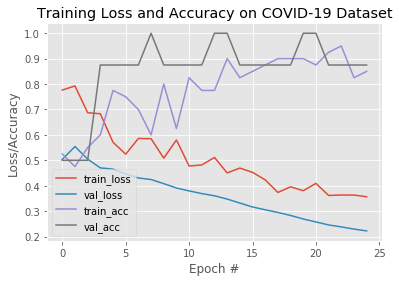

In [10]:
# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Finally, we serialize the tf.keras classifier model to disk.

In [11]:
# Serialize the model to disk
print("[INFO] Saving COVID-19 detector model...")
model.save("covid-19.model", save_format="h5")

[INFO] Saving COVID-19 detector model...
